In [1]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import sys
sys.path.append("/home/yang_liu/python_workspace/gaussian-splatting-lightning")

import torch
import random
from matplotlib import pyplot as plt
from gsplat.rasterize import rasterize_gaussians
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser
from internal.renderers.vanilla_renderer import VanillaRenderer
from internal.utils.sh_utils import eval_gaussian_model_sh

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
# load model and dataset
model, renderer = GaussianModelLoader.search_and_load(
    "../outputs/sci-art-pixsfm-app-swag5",
    sh_degree=3,
    device="cuda",
)
print("Gaussian count: {}".format(model.get_xyz.shape[0]))
# dataset
dataparser_outputs = ColmapDataParser(
    os.path.expanduser("../data/urban_scene_3d/sci-art-pixsfm/train"),
    os.path.abspath(""),
    global_rank=0,
    params=ColmapParams(
        eval_image_select_mode="ratio",
        eval_ratio=1.0,
        down_sample_factor=4,
        appearance_groups="appearance_group_by_image",
    ),
).get_outputs()
print("Test camera count: {}".format(len(dataparser_outputs.test_set.cameras)))

Gaussian count: 2803134


loading appearance groups from ../data/urban_scene_3d/sci-art-pixsfm/train/appearance_group_by_image
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 2998, val set images: 2998, loaded mask: 0
Test camera count: 2998


In [14]:
# pick a camera
idx = random.randint(0, len(dataparser_outputs.test_set.cameras) - 1)
camera = dataparser_outputs.test_set.cameras[idx].to_device("cuda")
image_path = dataparser_outputs.test_set.image_paths[idx]

torch.Size([3, 912, 1216])


(-0.5, 1215.5, 911.5, -0.5)

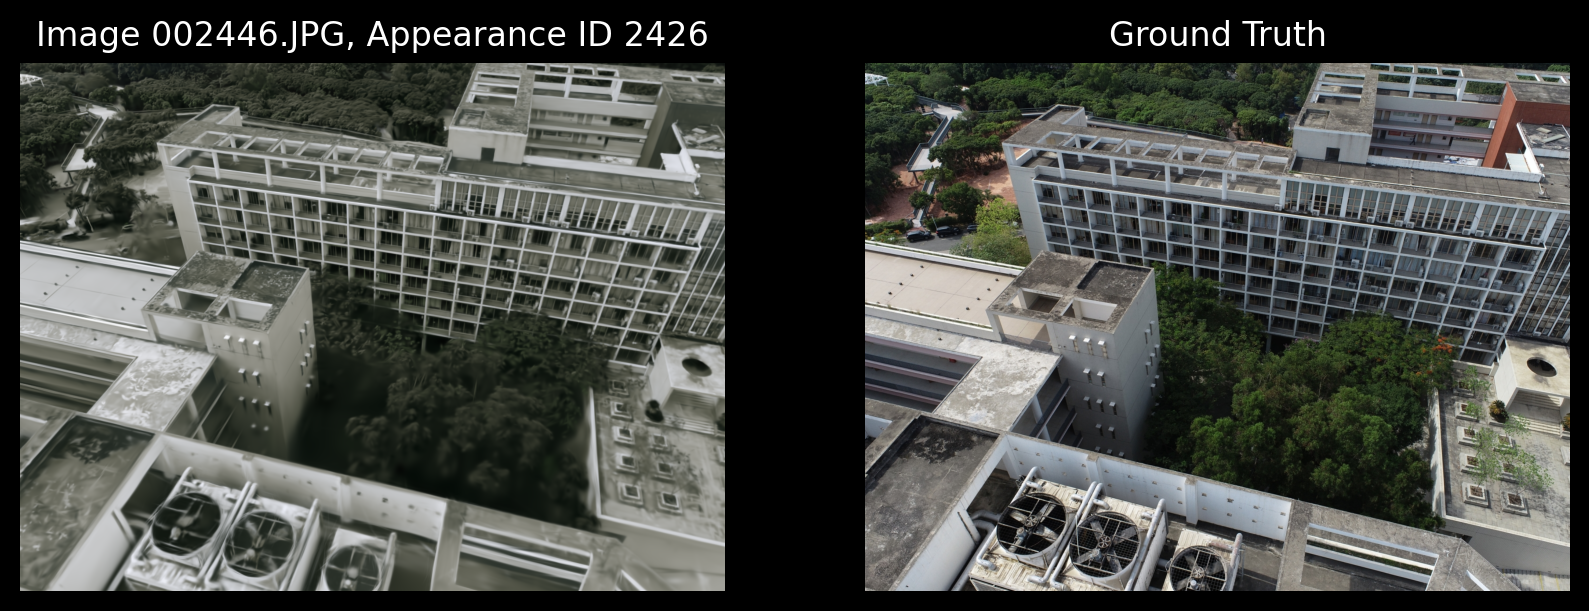

In [15]:
# Test image render
with torch.no_grad():
    gt = torch.tensor(plt.imread(image_path), dtype=torch.float, device="cuda").permute(2, 0, 1) / 255.0
    # results = VanillaRenderer.render(
    #     model.get_xyz,
    #     opacity=model.get_opacity,
    #     scales=model.get_scaling,
    #     rotations=model.get_rotation,
    #     features=model.get_features,
    #     active_sh_degree=model.active_sh_degree,
    #     viewpoint_camera=camera,
    #     bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"),
    # )
    results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    print(results["render"].shape)

plt.figure(figsize=(10, 5))
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.imshow(results["render"].permute(1, 2, 0).cpu().numpy())
plt.title(f"Image {dataparser_outputs.test_set.image_names[idx]}, Appearance ID {camera.appearance_id}")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(gt.permute(1, 2, 0).cpu().numpy())
plt.title("Ground Truth")
plt.axis('off')

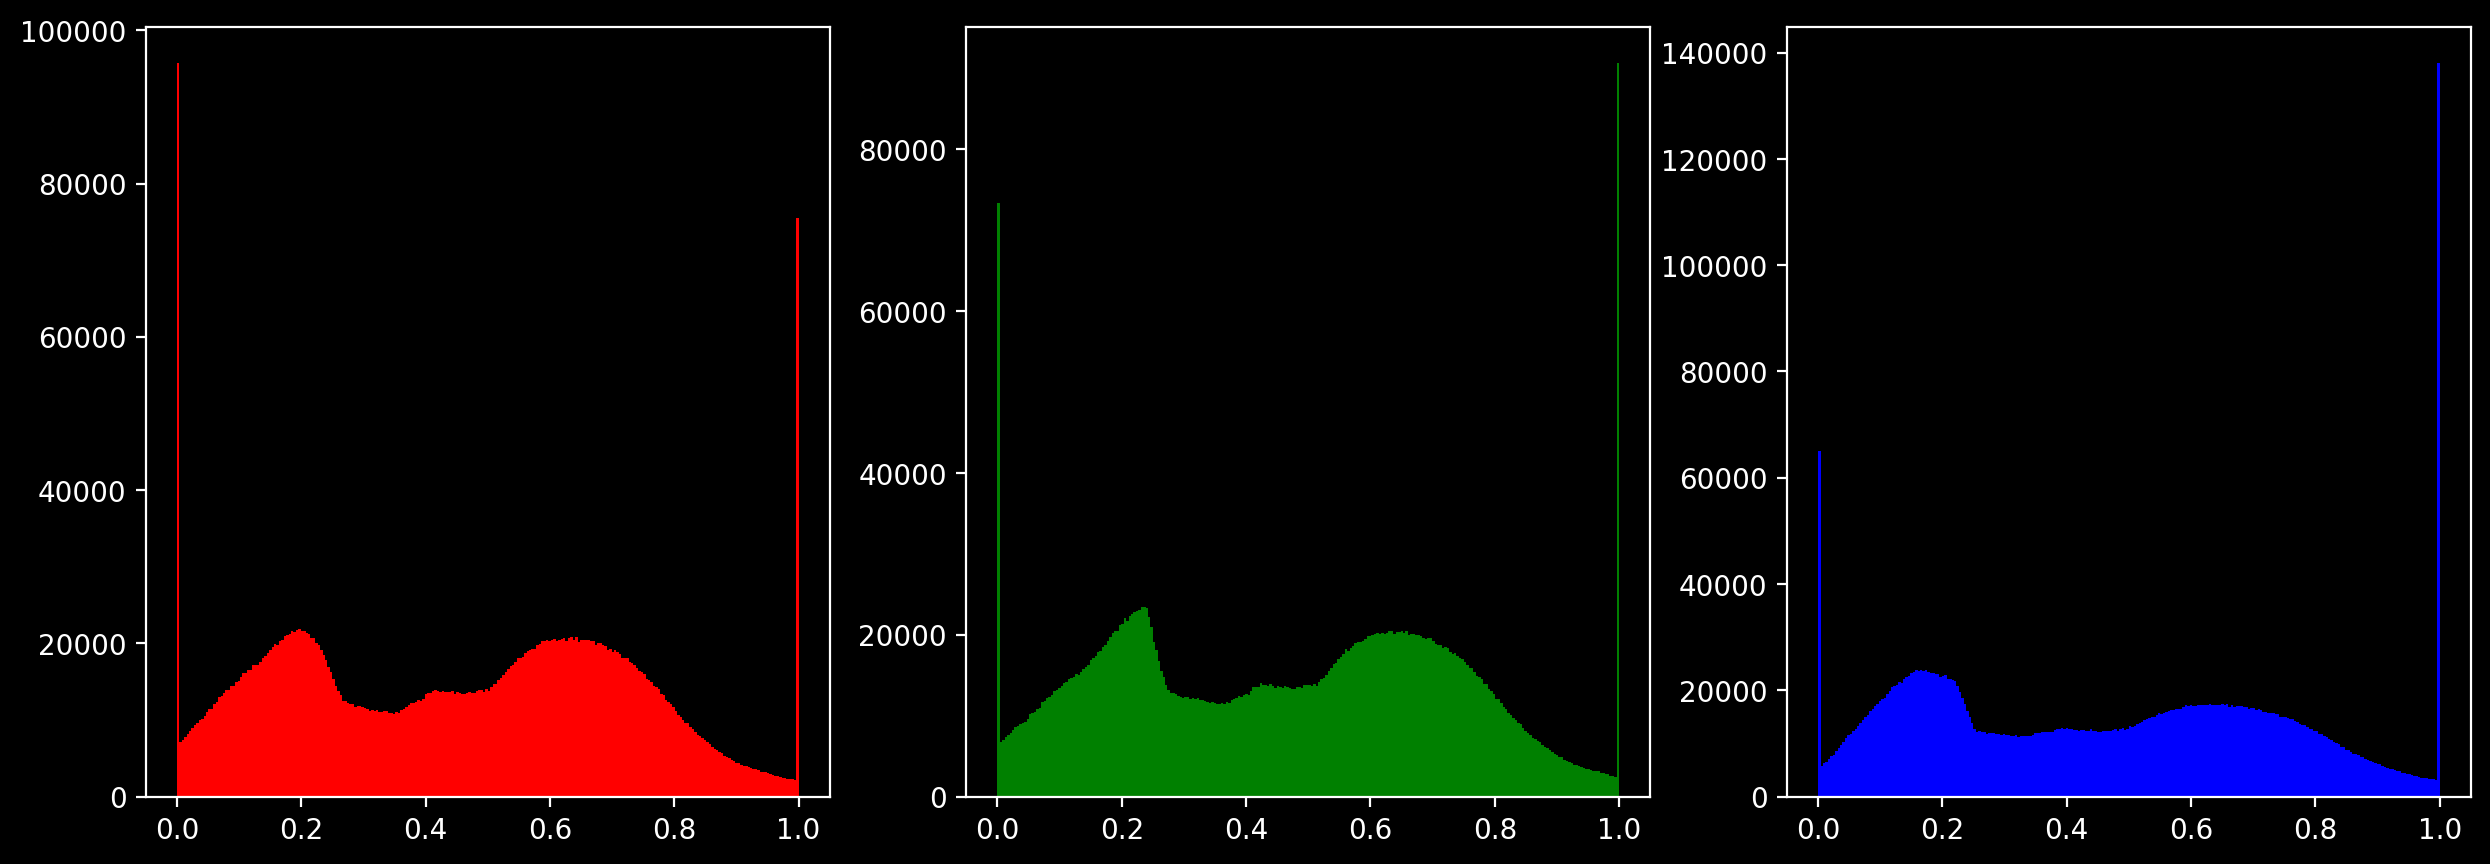

In [4]:
colors = eval_gaussian_model_sh(camera, model)  # [n, 3]
image_conditioned_colors, image_conditioned_delta_alpha = renderer.swag_model(colors, renderer._get_normalized_xyz(gaussian_model=model), camera.appearance_id)
image_conditioned_colors = image_conditioned_colors.cpu().numpy()

# get histogram of each channel of the image_conditioned_colors
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
hist_r = plt.hist(image_conditioned_colors[:, 0], bins=256, range=(0, 1), color='r')[0]
plt.subplot(1, 3, 2)
hist_g = plt.hist(image_conditioned_colors[:, 1], bins=256, range=(0, 1), color='g')[0]
plt.subplot(1, 3, 3)
hist_b = plt.hist(image_conditioned_colors[:, 2], bins=256, range=(0, 1), color='b')[0]
plt.show()

In [6]:
from internal.utils.ssim import ssim

print("SSIM: {:.4f}".format(ssim(results["render"], gt).item()))
print("L1: {:.4f}".format(torch.abs(results["render"] - gt).mean()))

SSIM: 0.8691
L1: 0.0397
